第一次使用QuantConnect，看了一些tutorial后大概了解了相关的运行逻辑。最开始遇到的问题也是最大的问题就是不知道如何定义一个Custom Universe 包含所有的S&P 500 Stocks，因为网上查了查没查到。有一个QuantConnect用户分享了S&P 500 Stocks的CSV file，于是便照着写了parse这些股票的方法：

In [1]:
# Reference：https://www.quantconnect.com/forum/discussion/3185/template-s-amp-p-500-custom-universe/p1
def load_sp500_data(self):

        if self.sp500_list is None:
            self.sp500_list = {}

            url = 'https://www.dropbox.com/scl/fi/lde50lci3emyu46afjx7j/data.csv?rlkey=fczdf1w96plksecepop1c01px&st=tqlfo0mh&dl=0'
            response = requests.get(url)
            file_content = response.content.decode('utf-8')

            file_content = re.sub(r'"', '', file_content)

            for line in file_content.splitlines():
                if not line:
                    continue

                csv_data = line.split(',')
                date = datetime.strptime(csv_data[0], '%Y-%m-%d')
                symbols = [symbol for symbol in csv_data[1:] if symbol.strip()]
                self.sp500_list[date] = symbols

def get_sp500_symbol_list(self, date_time):

    self.load_sp500_data()

    sorted_dates = sorted(self.sp500_list.keys(), reverse=True)
    result = next((self.sp500_list[date] for date in sorted_dates if date < date_time), None)

    if result is None:
        sorted_dates = sorted(self.sp500_list.keys())
        result = self.sp500_list[sorted_dates[0]]

    return result

但随后出现了新的问题，就是得到这个股票的list如何放进QuantConnect的Universe里。

In [ ]:
"""
在 initialize里尝试了以下的code
虽然可以用ManualUniverse，但不能定义5因子的fine selection，而要用到自己定义的FineSelectionFunction
就需要call self.AddUniverse(self.CoarseSelectionFunction, self.FineSelectionFunction)
但 AddUniverse 并不能选用我想要的SP500 Stocks
"""
date = datetime.strptime('2017-01-05', '%Y-%m-%d')
symbols = self.get_sp500_symbol_list(date)
self.SetUniverseSelection(ManualUniverseSelectionModel(sp500_symbols))

"""
然后尝试了 https://www.quantconnect.com/docs/v2/writing-algorithms/universes/custom-universes 提到的custom universe
但每个trading day QuantConnect的Universe Selection会call Reader，也就是那天的specific stocks。
而由于目前这个CSV不包含每个trading day的SP 500 stocks（不定时间更新），因此此方法也行不通。
"""
class MyCustomUniverseDataClass(PythonData):

    def get_source(self, config, date, isLive):
        return SubscriptionDataSource("https://docs.google.com/spreadsheets/d/12lUYUHYWNYhLBvJGcsXp2ZBXdJ7g3-Sspwvg0L62NAk/gviz/tq?tqx=out:csv&sheet=Backtest_CSV", SubscriptionTransportMedium.REMOTE_FILE, FileFormat.UNFOLDING_COLLECTION)

    def reader(self, config, line, date, isLive):
        json_response = json.loads(line)

        end_time = datetime.strptime(json_response[-1]["date"], '%Y-%m-%d') + timedelta(1)

        data = list()

        for json_datum in json_response:
            datum = MyCustomUniverseDataClass()
            datum.symbol = Symbol.create(json_datum["Ticker"], SecurityType.EQUITY, Market.USA)
            datum.time = datetime.strptime(json_datum["date"], '%Y-%m-%d')
            datum.end_time = datum.time + timedelta(1)
            datum['CustomAttribute1'] = int(json_datum['Attr1'])
            datum.value = float(json_datum['Attr1'])
            data.append(datum)

        return BaseDataCollection(end_time, config.symbol, data)

最后尝试了自定义CoarseSelectionFunction：

In [ ]:
def CoarseSelectionFunction(self, coarse):
        date = datetime.strptime('2017-01-05', '%Y-%m-%d')
        symbols = self.get_sp500_symbol_list(date)
        selected = [x.Symbol for x in coarse if x.Symbol in symbols and x.HasFundamentalData]
        return [x.Symbol for x in selected]

然后就可以call QCAlgorithm里自带的AddUniverse了：

In [ ]:
self.AddUniverse(self.CoarseSelectionFunction, self.FineSelectionFunction)

然后写根据5因子选取股票的逻辑：
这里只写了
a. Select the top 400 stocks based on factor 1 (e.g., value).

b. From the 400 stocks, choose the top 300 based on factor 2.

c. Finally, select 20 to 100 stocks from the previous step as the final list for rebalancing.

我推测没写全的是based on factor 3, choose top 200; based on factor 4, choose top 100; 最后based on ROE, choose top 20 to 100.


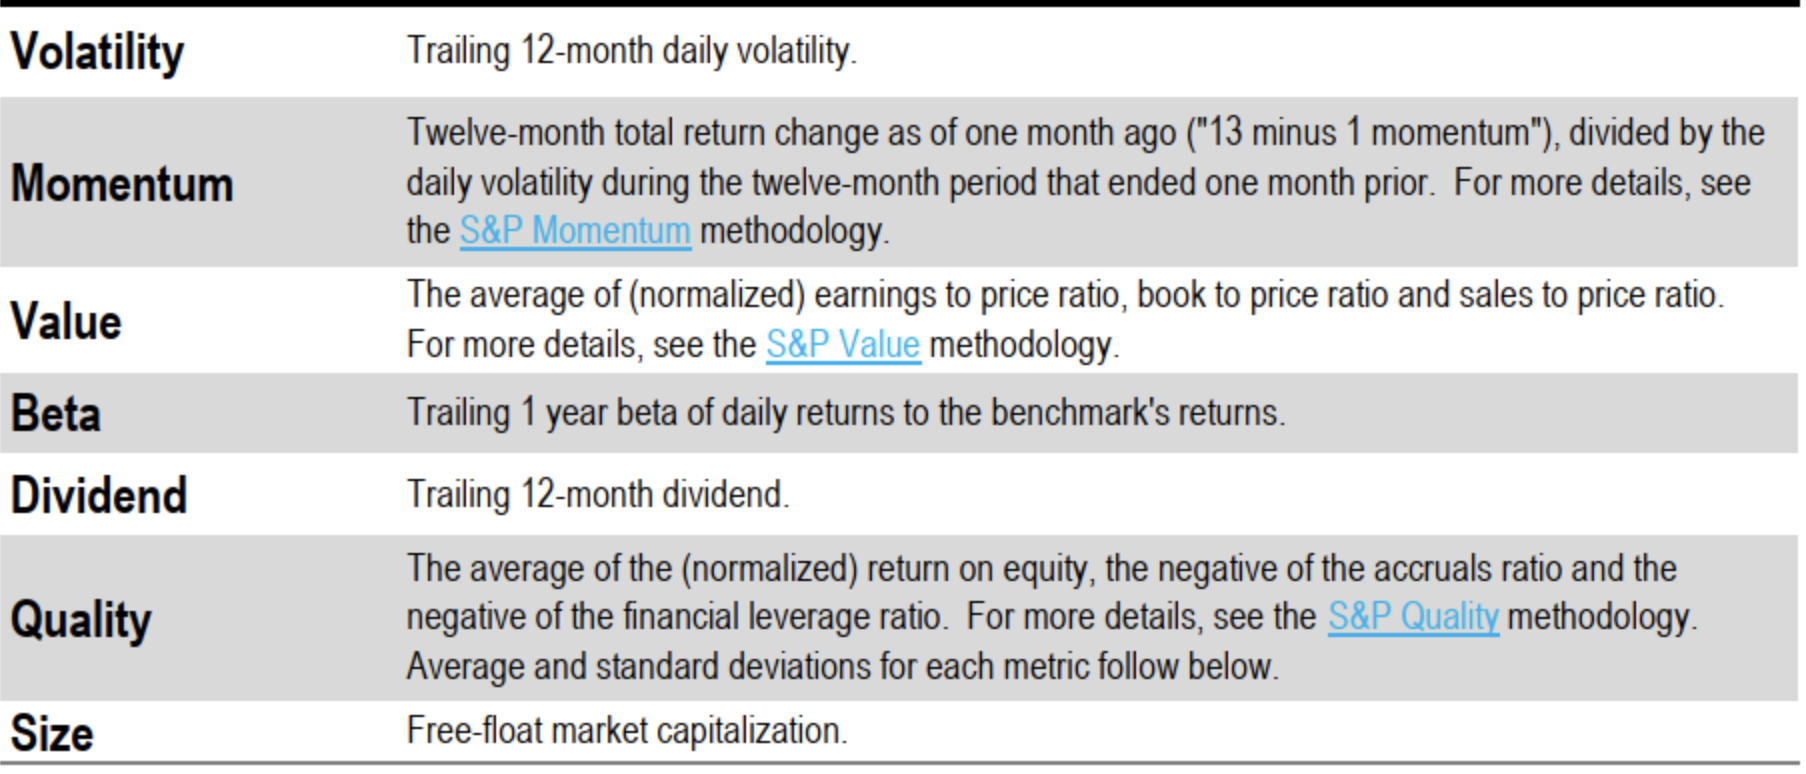

In [8]:
from IPython.display import Image, display
display(Image('截屏2024-05-07 下午1.11.41.png'))

In [ ]:
def FineSelectionFunction(self, fine):
        # 确保都不是None
        filtered = [x for x in fine if self.MOM(x.Symbol, 12)
                                    and x.ValuationRatios.PERatio
                                    and x.ValuationRatios.PBRatio
                                    and x.ValuationRatios.PSRatio
                                    and x.OperationRatios.ROE]

        # 选用动量当第一个因子并sort
        sortedbyMOM = sorted(filtered, key = lambda x: self.MOM(x.Symbol, 12), reverse = True)[:400]
        # 根据定义计算价值因子
        value = self.find_value(sortedbyMOM)
        sortedbyValue = sorted(sortedbyMOM, key = lambda x: value[x.Symbol], reverse = True)[:300]
        # 选用市值当第三个因子
        sortedbySize = sorted(sortedbyValue, key = lambda x: x.MarketCap)[:200]
        # 计算volatility当第四个因子
        volatility = self.find_volatility(sortedbySize)
        sortedbyVolatility = sorted(sortedbySize, key = lambda x: volatility[x.Symbol], reverse = True)[:100]
        # 最后根据ROE选择最后的股票
        sortedbyROE = sorted(sortedbyVolatility, key = lambda x: x.OperationRatios.ROE.Value, reverse = True)[:20]
        return [x.Symbol for x in sortedbyROE]

def find_value(self, sortedbyMOM):
        symbols = [x.Symbol for x in sortedbyMOM]
        pe_values = [x.ValuationRatios.PERatio for x in sortedbyMOM]
        pb_values = [x.ValuationRatios.PBRatio for x in sortedbyMOM]
        ps_values = [x.ValuationRatios.PSRatio for x in sortedbyMOM]
        # 用Minmax normalize
        scaler = MinMaxScaler()
        pe_values = np.array(pe_values).reshape(-1, 1)
        pb_values = np.array(pb_values).reshape(-1, 1)
        ps_values = np.array(ps_values).reshape(-1, 1)
        normalized_pe = scaler.fit_transform(pe_values).flatten()
        normalized_pb = scaler.fit_transform(pb_values).flatten()
        normalized_ps = scaler.fit_transform(ps_values).flatten()
        value = {}
        # 算平均数 output出dictionary
        for i, symbol in enumerate(symbols):
            value[symbol] = (normalized_pe[i] + normalized_pb[i] + normalized_ps[i]) / 3
        return value

def find_volatility(self, sortedbySize):
        symbols = [x.Symbol for x in sortedbySize]
        volatility = {}
        for x in symbols:
            history = self.History(x, 252, Resolution.Daily)
            if history.empty:
                volatility[x] = np.nan
                continue
            close_prices = history['close'].values
            r = np.diff(np.log(close_prices))
            r_mean = np.mean(r)
            diff_square = [(r[i]-r_mean)**2 for i in range(0,len(r))]
            sigma = np.sqrt(sum(diff_square)*(1.0/(len(r)-1)))
            vol = sigma*np.sqrt(252)
            volatility[x] = vol
        return volatility

没找到Quantconnect自带的Normalize function，于是import了MinMaxScalar来normalize。

Reference：
动量因子参考了QuantConnect自带的MOM，https://github.com/QuantConnect/Lean/blob/master/Indicators/Momentum.cs
https://www.quantconnect.com/docs/v2/writing-algorithms/indicators/supported-indicators/momentum

ROE参考了https://www.lean.io/docs/v2/lean-engine/class-reference/classQuantConnect_1_1Data_1_1Fundamental_1_1ROE.html

市值参考了https://www.quantconnect.com/forum/discussion/6521/how-to-filter-universe-on-market-cap/

Volatility参考了https://www.quantconnect.com/learning/articles/introduction-to-options/historical-volatility-and-implied-volatility




最后是设置Rebalance，在查询很多资料后了解到
1. CoarseSelectionFunction是被called daily的，也就是
AddUniverse is called daily, 但可以加一个check让每个rebalance day前的universe不变。
2. 用OnData check是不是要rebalance了，会用到SetHoldings和liquidate function。
3. 因此在进入self.time >= self._nextLiquidate时，QuantConnect已经有了在这个rebalance day选用的股票。

In [ ]:
def on_data(self, data: Slice):
        '''Rebalance Every `self._rebalance_days`'''

        # Liquidate stocks in the end of every month
        if self.Time >= self.nextLiquidate:
            for holding in self.Portfolio.Values:
                # If the holding is in the stock list for the next month, don't liquidate
                if holding.Symbol in self.symbols_selected:
                    continue
                # If the holding is not in the list, liquidate
                if holding.Invested:
                    self.Liquidate(holding.Symbol)

            count = len(self.symbols_selected)

            # It means the long & short lists for the month have been cleared
            if count == 0:
                return

            # Open positions at the start of every month
            for symbol in self.symbols_selected:
                self.SetHoldings(symbol, 1/count)

            # Set the next liquidation date
            self.nextLiquidate = self.Time + timedelta(self.rebalance_days)

            # After opening positions, clear the symbol lists until next universe selection
            self.symbols_selected.clear()

最后还是卡在SP500股票的读取上，上述方法会有Runtime error Max retries exceeded with url，QuantConnect网站上也没找到upload dataset的方法。也尝试了https://www.quantconnect.com/docs/v2/writing-algorithms/importing-data/streaming-data/key-concepts 上提到的import data.

In [ ]:
class SP500SymbolData(PythonData):
    def GetSource(self, config, date, isLiveMode):
        source = 'https://www.dropbox.com/scl/fi/lde50lci3emyu46afjx7j/data.csv?rlkey=fczdf1w96plksecepop1c01px&raw=1'
        return SubscriptionDataSource(source, SubscriptionTransportMedium.RemoteFile)

    def Reader(self, config, line, date, isLiveMode):
        data = SP500SymbolData()
        try:
            # Split the CSV line into fields
            csv_data = line.split(',')
            if len(csv_data) < 2:
                return None

            # Parse the date field
            try:
                data.Time = datetime.strptime(csv_data[0], '%Y-%m-%d')
            except ValueError:
                return None

            symbols = ','.join([symbol.strip() for symbol in csv_data[1:] if symbol.strip()])
            data.Value = 0

            # Store the data as a property
            data.SetProperty("Symbols", symbols)
            data.Symbol = config.Symbol

            return data
        except:
            return None

最后hard-code了S&P 500 stocks，debug后的最终版本：

In [ ]:
# region imports
from AlgorithmImports import *
from datetime import datetime
import requests
import re
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
# endregion

class FiveFactorModel(QCAlgorithm):
    def initialize(self):
        self.sp500_list = None
        self.SetStartDate(2017, 1, 1)
        self.SetEndDate(2023, 8, 1)
        self.SetCash(100000)
        self.symbols_selected=[]
        # self designed Coarse and Fine selection function
        self.AddUniverse(self.CoarseSelectionFunction, self.FineSelectionFunction)
        self.UniverseSettings.Resolution = Resolution.Daily
        self.nextLiquidate = self.time   # Initialize last trade time
        self.rebalance_days = 30
        self.SetWarmUp(timedelta(days=252))

    def CoarseSelectionFunction(self, coarse):

        if self.Time < self.nextLiquidate:
            return Universe.UNCHANGED
        # hard-coded S&P 500
        symbols = ["A", "AAL", "AAP", ... , "ZTS"]
        return [x.Symbol for x in coarse if x.HasFundamentalData and x.Symbol.Value in symbols]

    def FineSelectionFunction(self, fine):
        # filter out the symbols with all data available
        filtered = [
            x for x in fine if
            self.MOM(x.Symbol, 13) is not None and
            x.ValuationRatios.PERatio is not None and
            x.ValuationRatios.PBRatio is not None and
            x.ValuationRatios.PSRatio is not None and
            x.OperationRatios.ROE is not None and
            x.OperationRatios.ROE is not None
        ]
        # Select the top 400 stocks based on factor 1 - Momentum
        sortedbyMOM = sorted(filtered, key = lambda x: self.MOM(x.Symbol, 13), reverse = True)[:400]
        value = self.find_value(sortedbyMOM)
        # Select the top 300 stocks based on factor 2 - Value
        sortedbyValue = sorted(sortedbyMOM, key = lambda x: value[x.Symbol], reverse = True)[:300]
        # Select the top 200 stocks based on factor 3 - Size
        sortedbySize = sorted(sortedbyValue, key = lambda x: x.MarketCap)[:200]
        volatility = self.find_volatility(sortedbySize)
        # Select the top 100 stocks based on factor 4 - Volatility
        sortedbyVolatility = sorted(sortedbySize, key = lambda x: volatility[x.Symbol], reverse = True)[:100]
        # Finally, select the top 20 stocks based on ROE
        sortedbyROE = sorted(sortedbyVolatility, key = lambda x: x.OperationRatios.ROE.Value, reverse = True)[:20]
        self.symbols_selected = [x.Symbol for x in sortedbyROE]
        return [x.Symbol for x in sortedbyROE]

    def find_value(self, sortedbyMOM):
        symbols = [x.Symbol for x in sortedbyMOM]
        # get the PE, PB, PS values
        pe_values = [x.ValuationRatios.PERatio for x in sortedbyMOM]
        pb_values = [x.ValuationRatios.PBRatio for x in sortedbyMOM]
        ps_values = [x.ValuationRatios.PSRatio for x in sortedbyMOM]
        # normalize
        scaler = MinMaxScaler()
        pe_values = np.array(pe_values).reshape(-1, 1)
        pb_values = np.array(pb_values).reshape(-1, 1)
        ps_values = np.array(ps_values).reshape(-1, 1)
        normalized_pe = scaler.fit_transform(pe_values).flatten()
        normalized_pb = scaler.fit_transform(pb_values).flatten()
        normalized_ps = scaler.fit_transform(ps_values).flatten()
        value = {}
        for i, symbol in enumerate(symbols):
            value[symbol] = (normalized_pe[i] + normalized_pb[i] + normalized_ps[i]) / 3
        return value

    def find_volatility(self, sortedbySize):
        symbols = [x.Symbol for x in sortedbySize]
        volatility = {}
        for x in symbols:
            history = self.History(x, 252, Resolution.Daily)
            if history.empty:
                # Assign NaN if history is empty
                volatility[x] = np.nan
                continue
            # Extract the closing prices
            close_prices = history['close'].values
            r = np.diff(np.log(close_prices))
            r_mean = np.mean(r)
            diff_square = [(r[i]-r_mean)**2 for i in range(0,len(r))]
            sigma = np.sqrt(sum(diff_square)*(1.0/(len(r)-1)))
            vol = sigma*np.sqrt(252)
            volatility[x] = vol
        return volatility

    def MOM(self, symbol, months=13):
        period = months * 21
        offset = 21
        history = self.History(symbol, period + offset, Resolution.Daily)
        # (13 - 1) months change
        if not history.empty and len(history) >= period + offset:
            start_price = history["close"].iloc[0]
            end_price = history["close"].iloc[-offset]
            return (end_price - start_price) / start_price
        return None

    def on_data(self, data: Slice):
        # Liquidate stocks in the end of every month
        if self.Time >= self.nextLiquidate:
            for holding in self.Portfolio.Values:
                # If the holding is in the stock list for the next month, don't liquidate
                if holding.Symbol in self.symbols_selected:
                    continue
                # If the holding is not in the list, liquidate
                if holding.Invested:
                    self.Liquidate(holding.Symbol)

            count = len(self.symbols_selected)

            if count == 0:
                return

            # Open positions at the start of every month
            for symbol in self.symbols_selected:
                if data.ContainsKey(symbol) and data[symbol] is not None:
                    self.SetHoldings(symbol, 1 / count)

            # Set the next liquidation date
            self.nextLiquidate = self.Time + timedelta(self.rebalance_days)

            # After opening positions, clear the symbol lists until next universe selection
            self.symbols_selected.clear()

写完后又有了个新的想法，就是把因子选股的逻辑都放到OnData里，这样就不用必须用AddUniverse了。在查如何选取SP 500股票的时候发现QuantConnect有built-in的另一些Universe, 如QCUniverse，这样就直接SetUniverseSelection(QC500UniverseSelectionModel) 就能抓到所有QC股票了。

在测试/debug的时候发现CoarseSelectionFunction写错了，并没有选择Sp500的股票而是在全美股里选，也产生了很荒诞的结果。可能是数据有错误，美股里TOPS这只股票在2020年8月份有接近3000%的return，因此也在修改好Coarse Selection后在OnData加了控制outlier的代码。

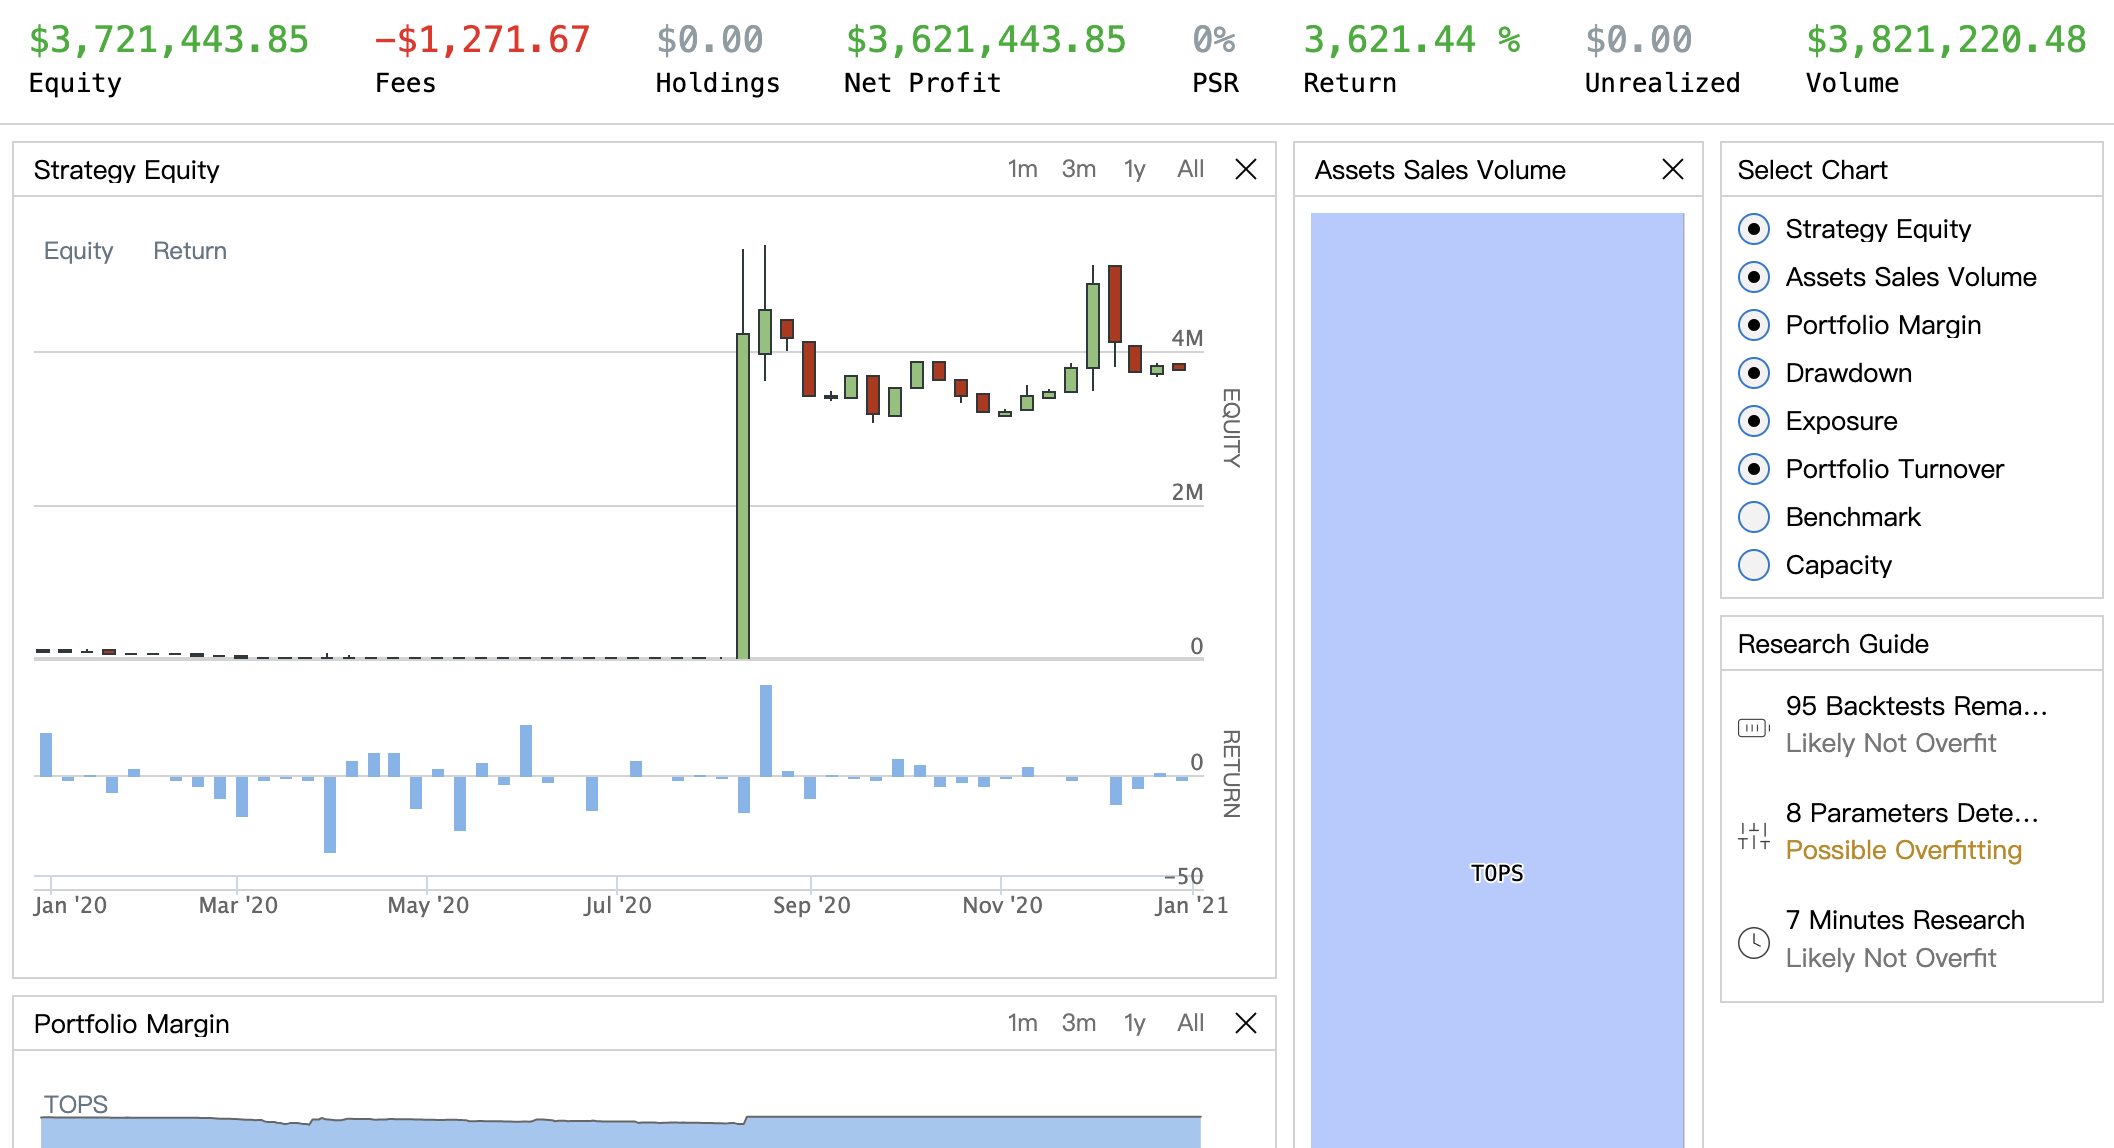

In [9]:
display(Image('截屏2024-05-08 下午2.43.53.png'))

In [ ]:
'''
max_alloc = min(1 / count, 0.1)
            # Open positions at the start of every month
for symbol in self.symbols_selected:
      if data.ContainsKey(symbol) and data[symbol] is not None:
            self.SetHoldings(symbol, max_alloc)
'''

最终结果：

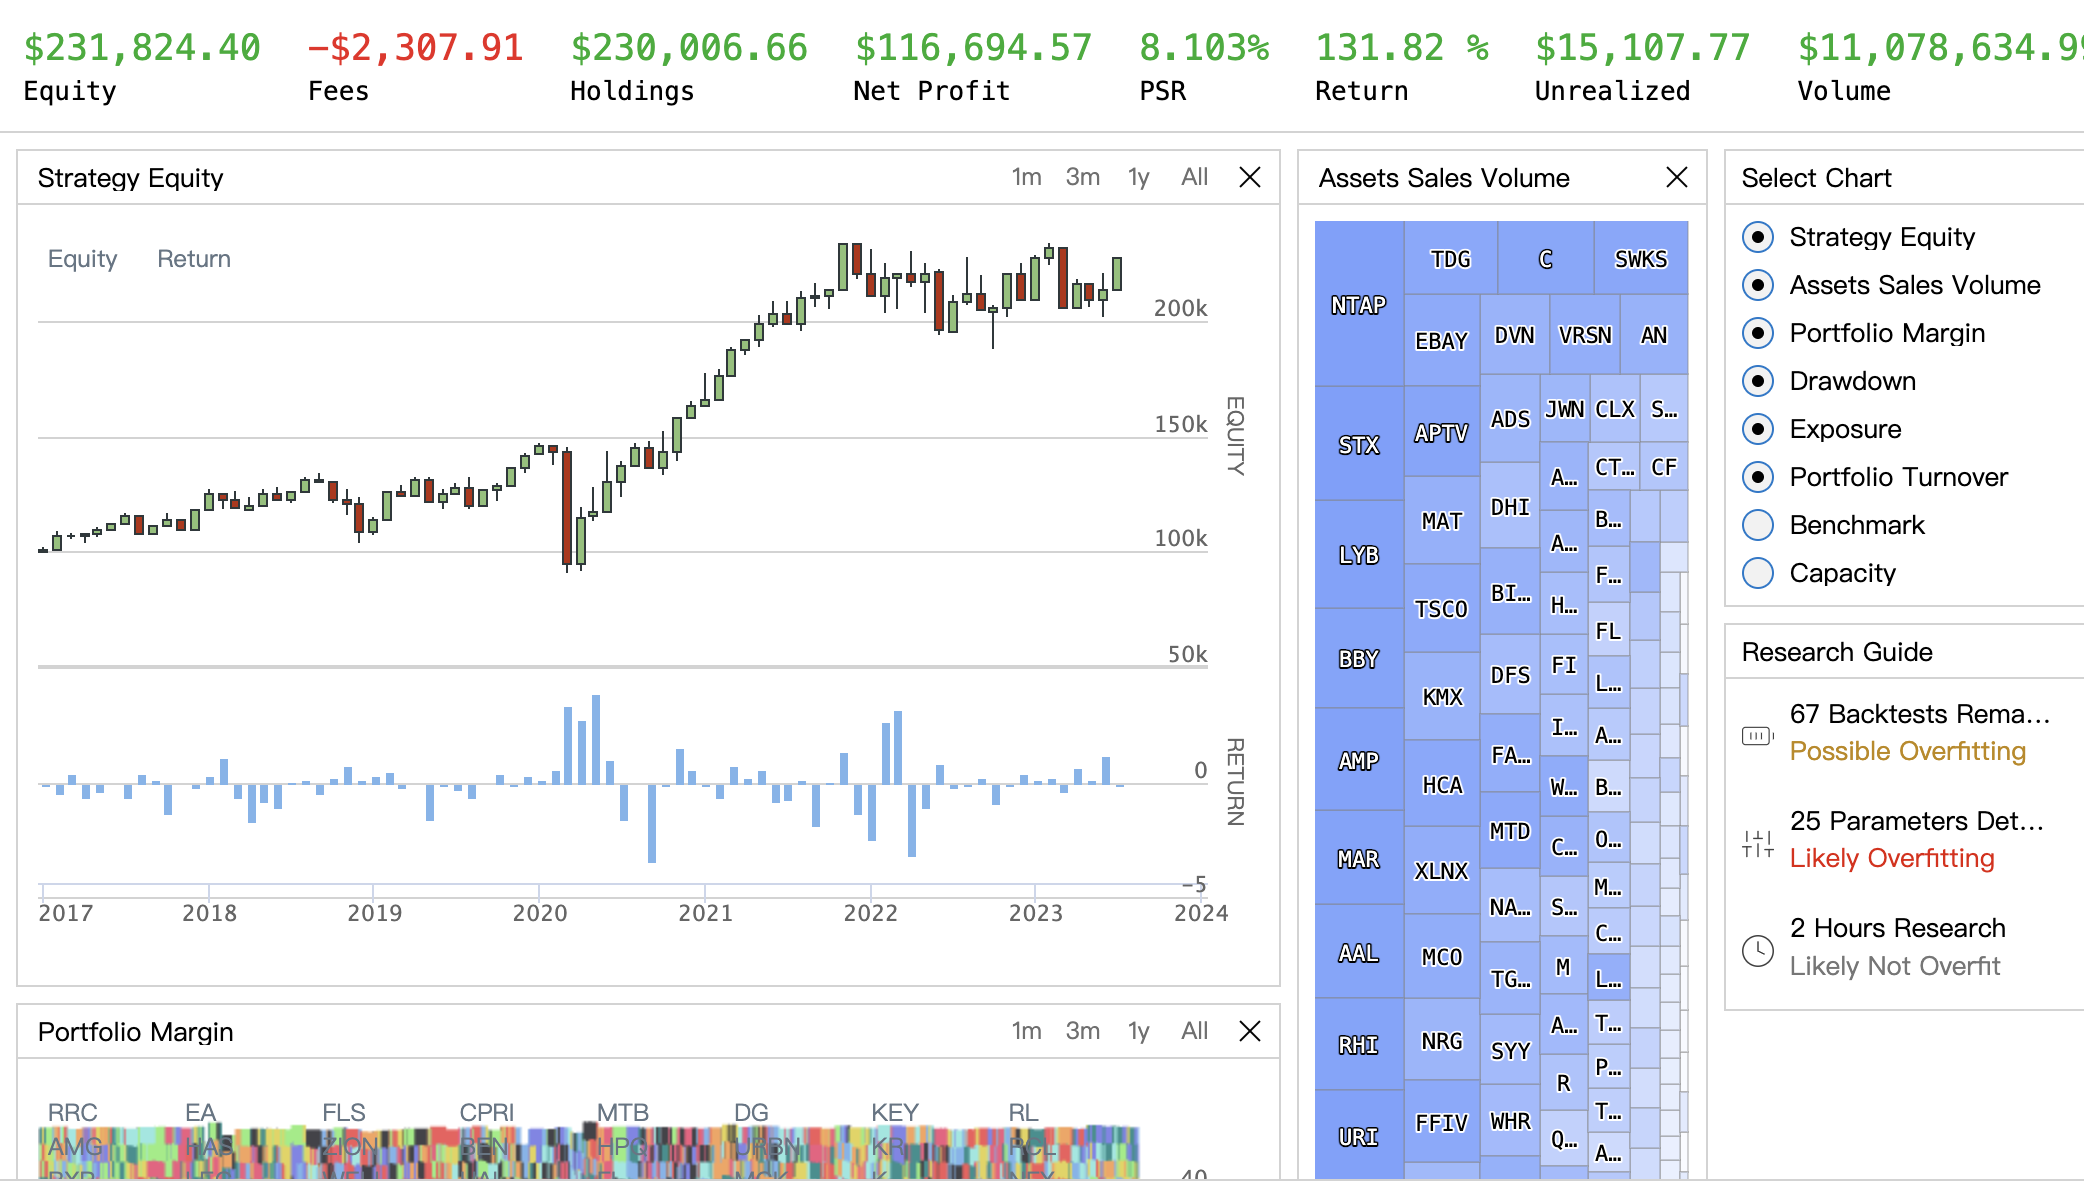

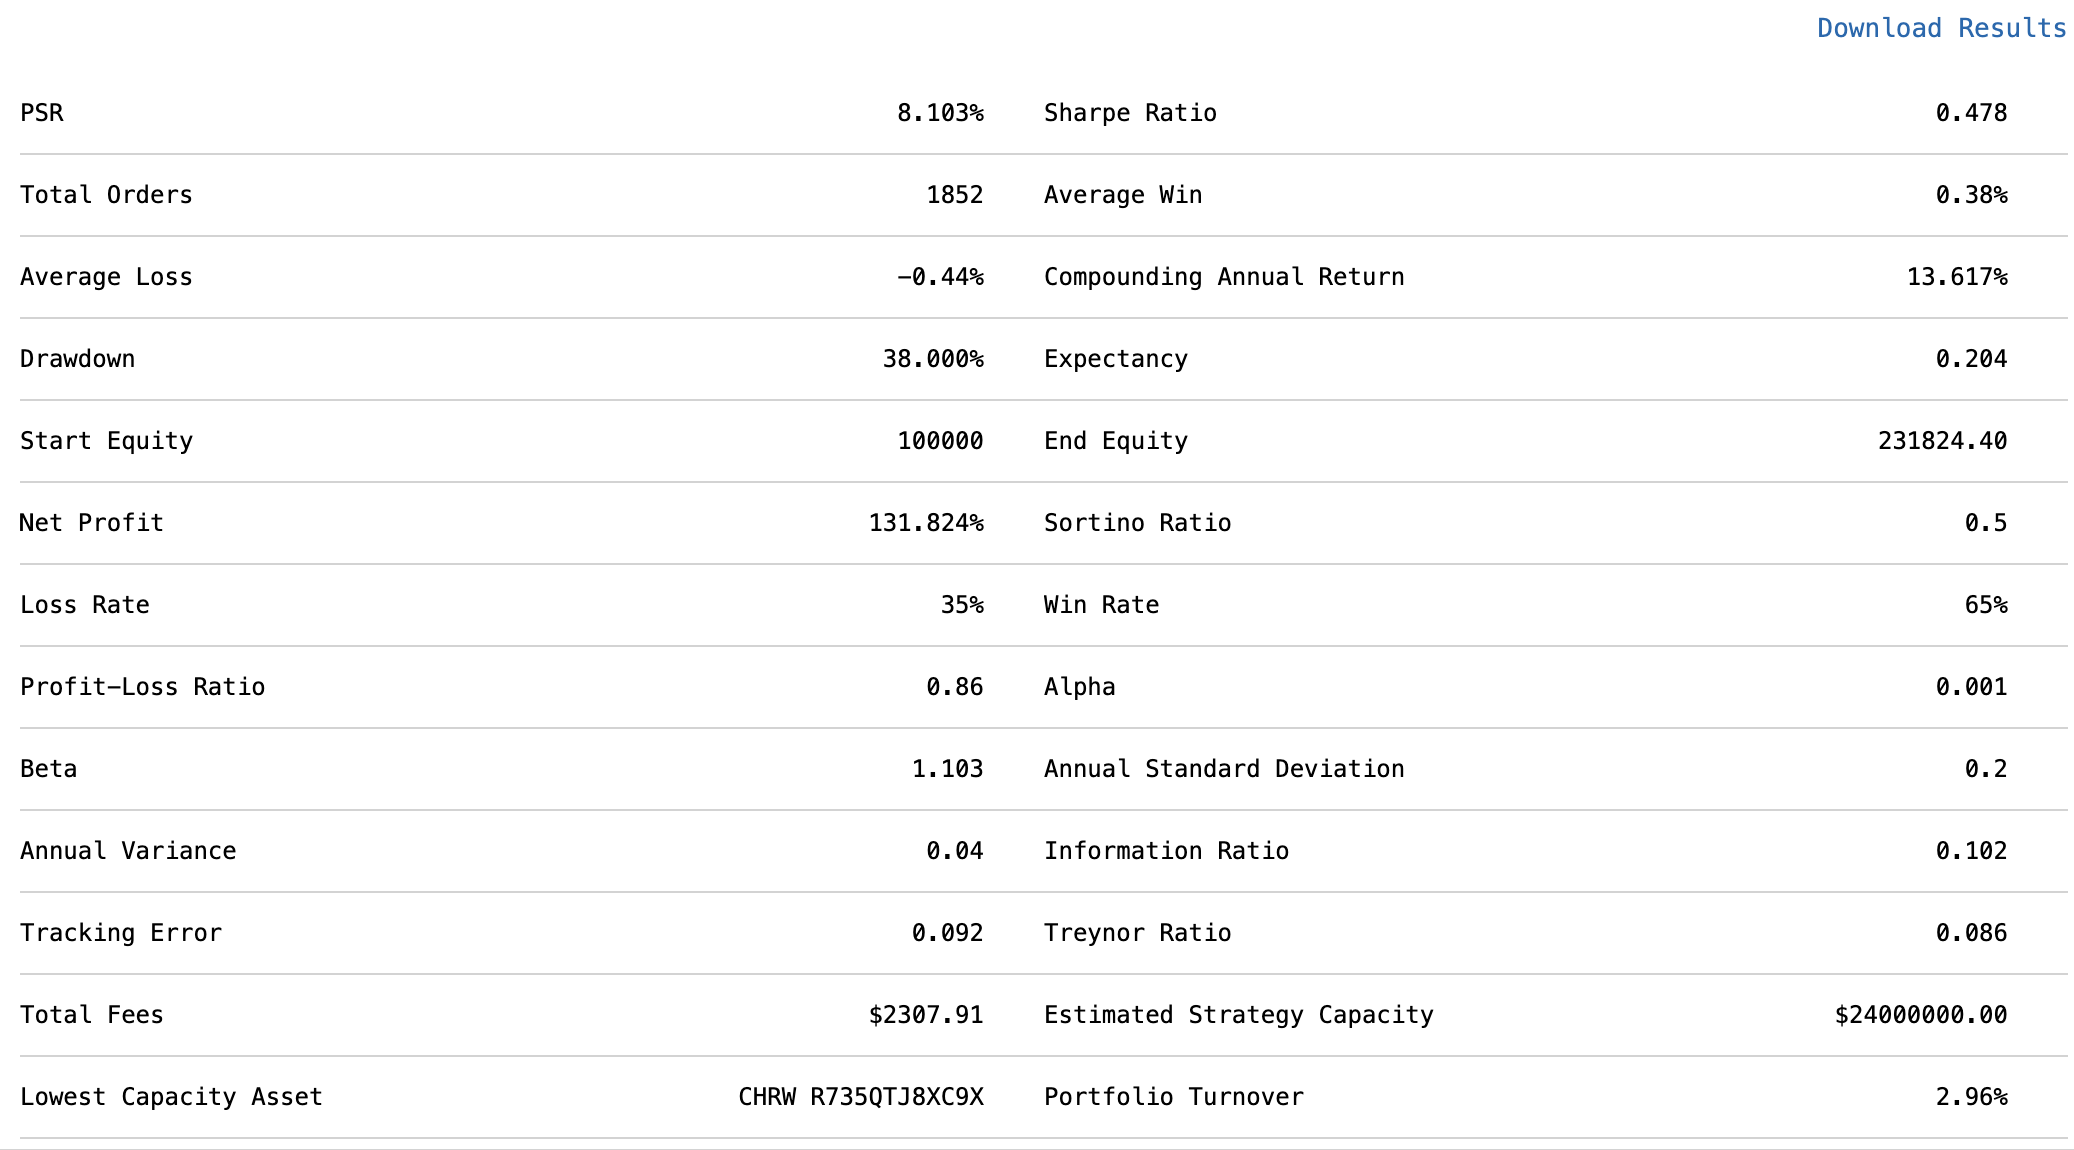

In [10]:
display(Image('截屏2024-05-08 下午3.14.30.png'))
display(Image('截屏2024-05-08 下午3.18.08.png'))

尝试加了5%止损并没有更好的表现：

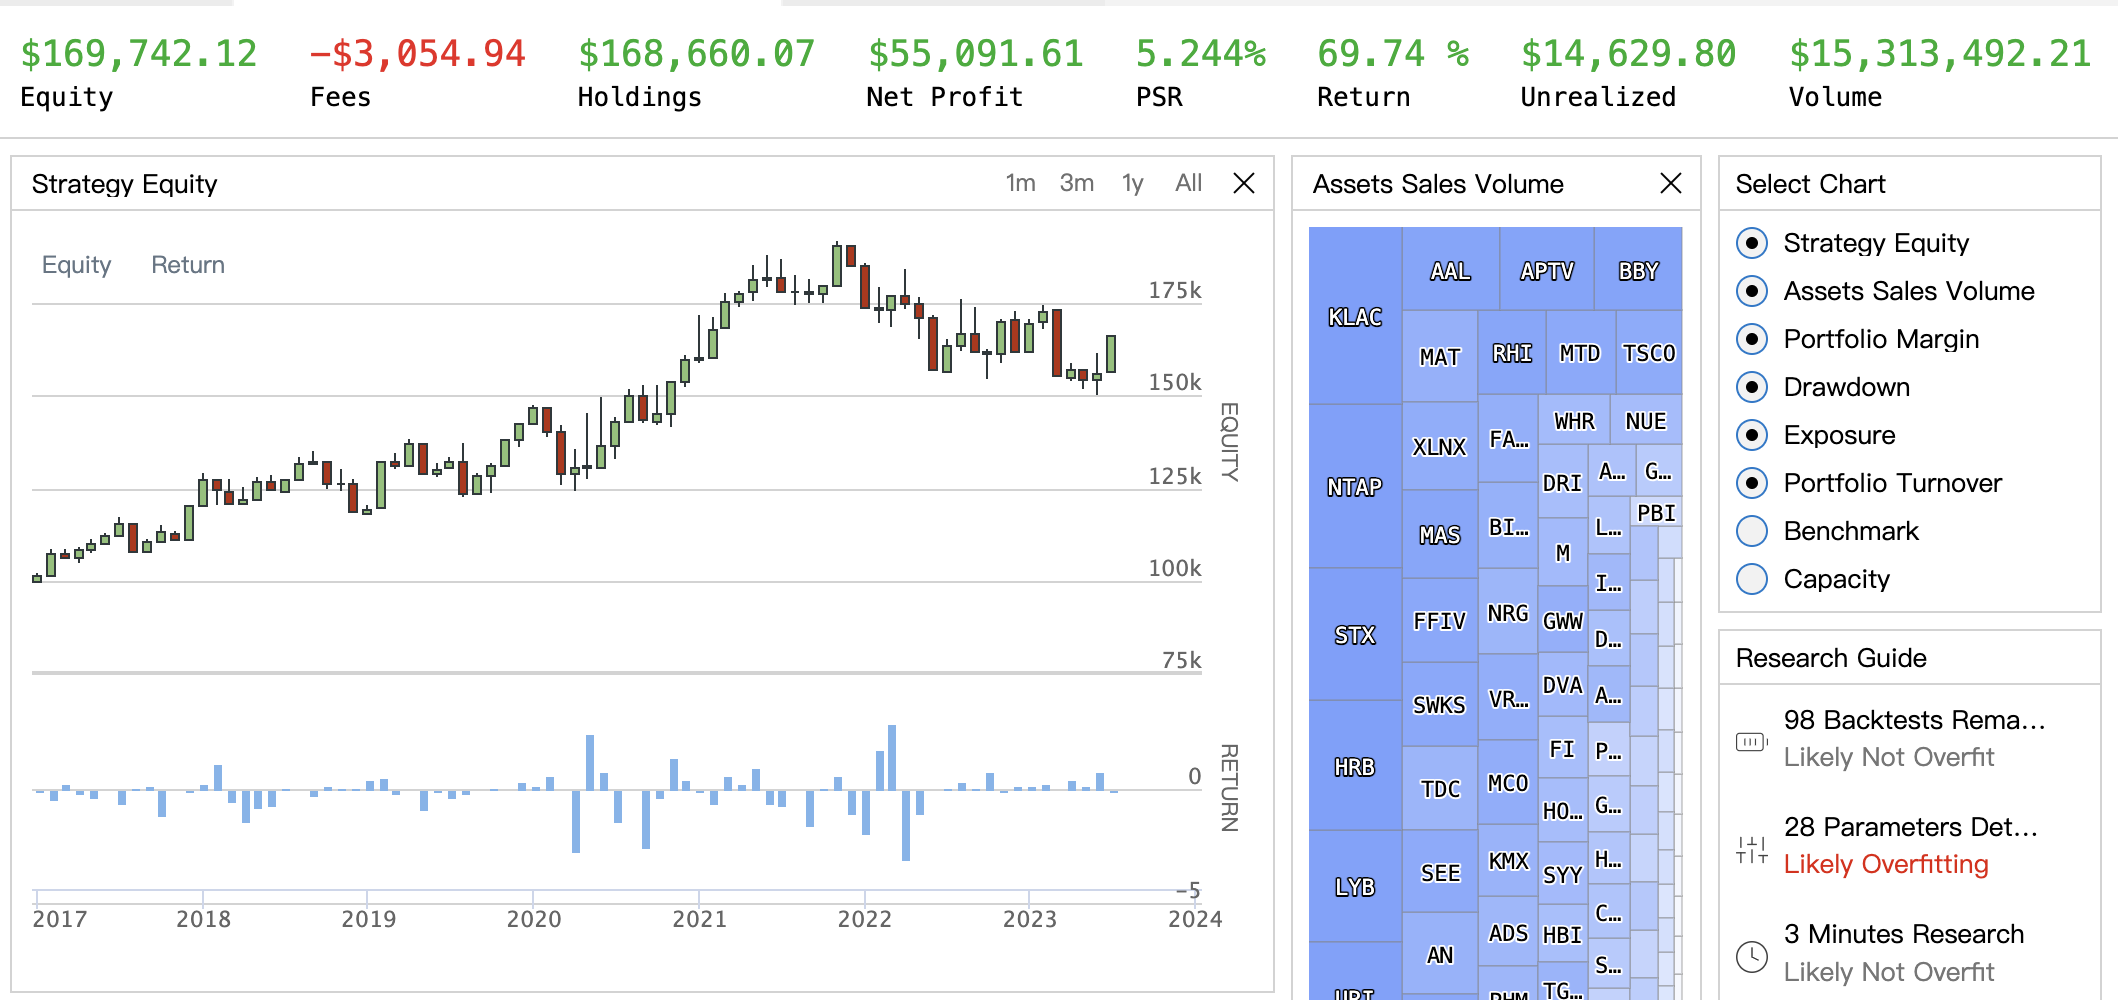

In [12]:
display(Image('截屏2024-05-08 下午3.55.57.png'))

将最后ROE选股改成选50股，其他不变：

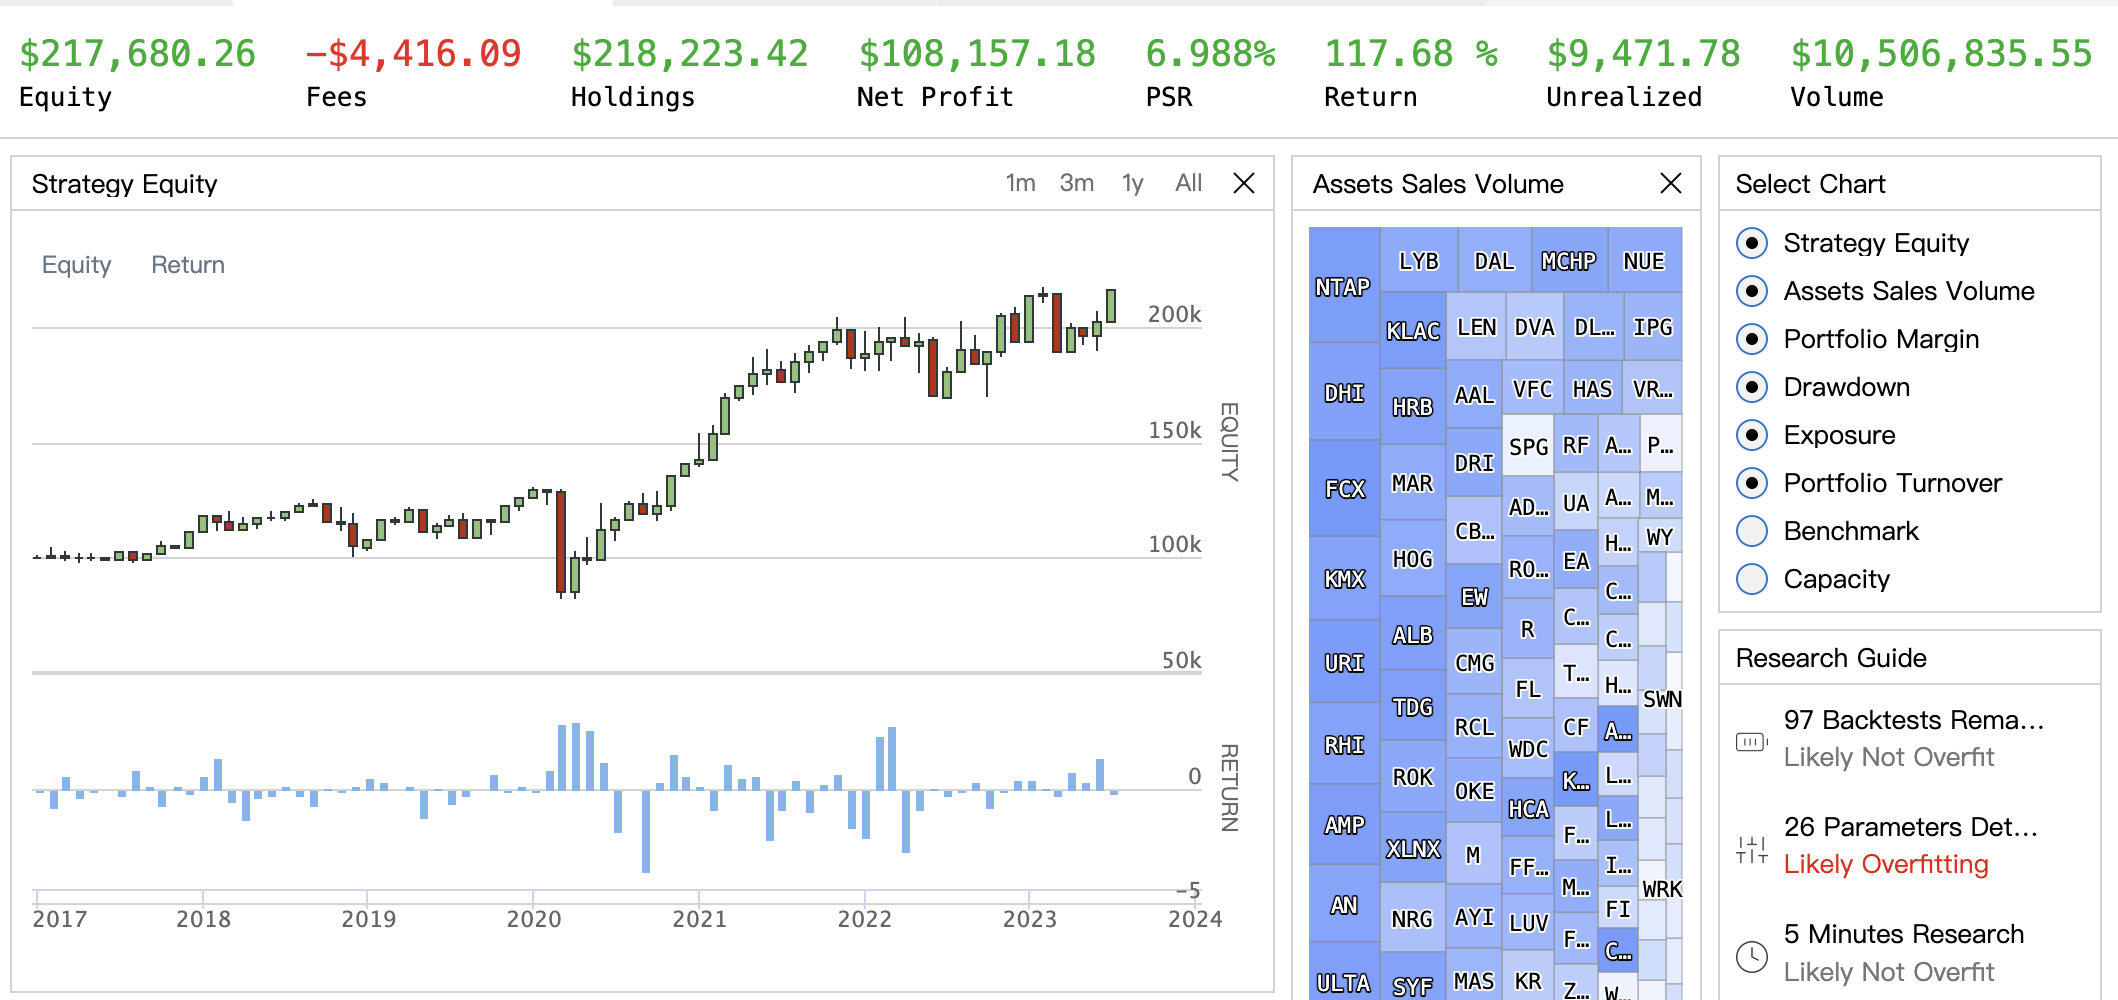

In [13]:
display(Image('截屏2024-05-08 下午4.21.11.png'))

将月度换仓改成半月度换仓：

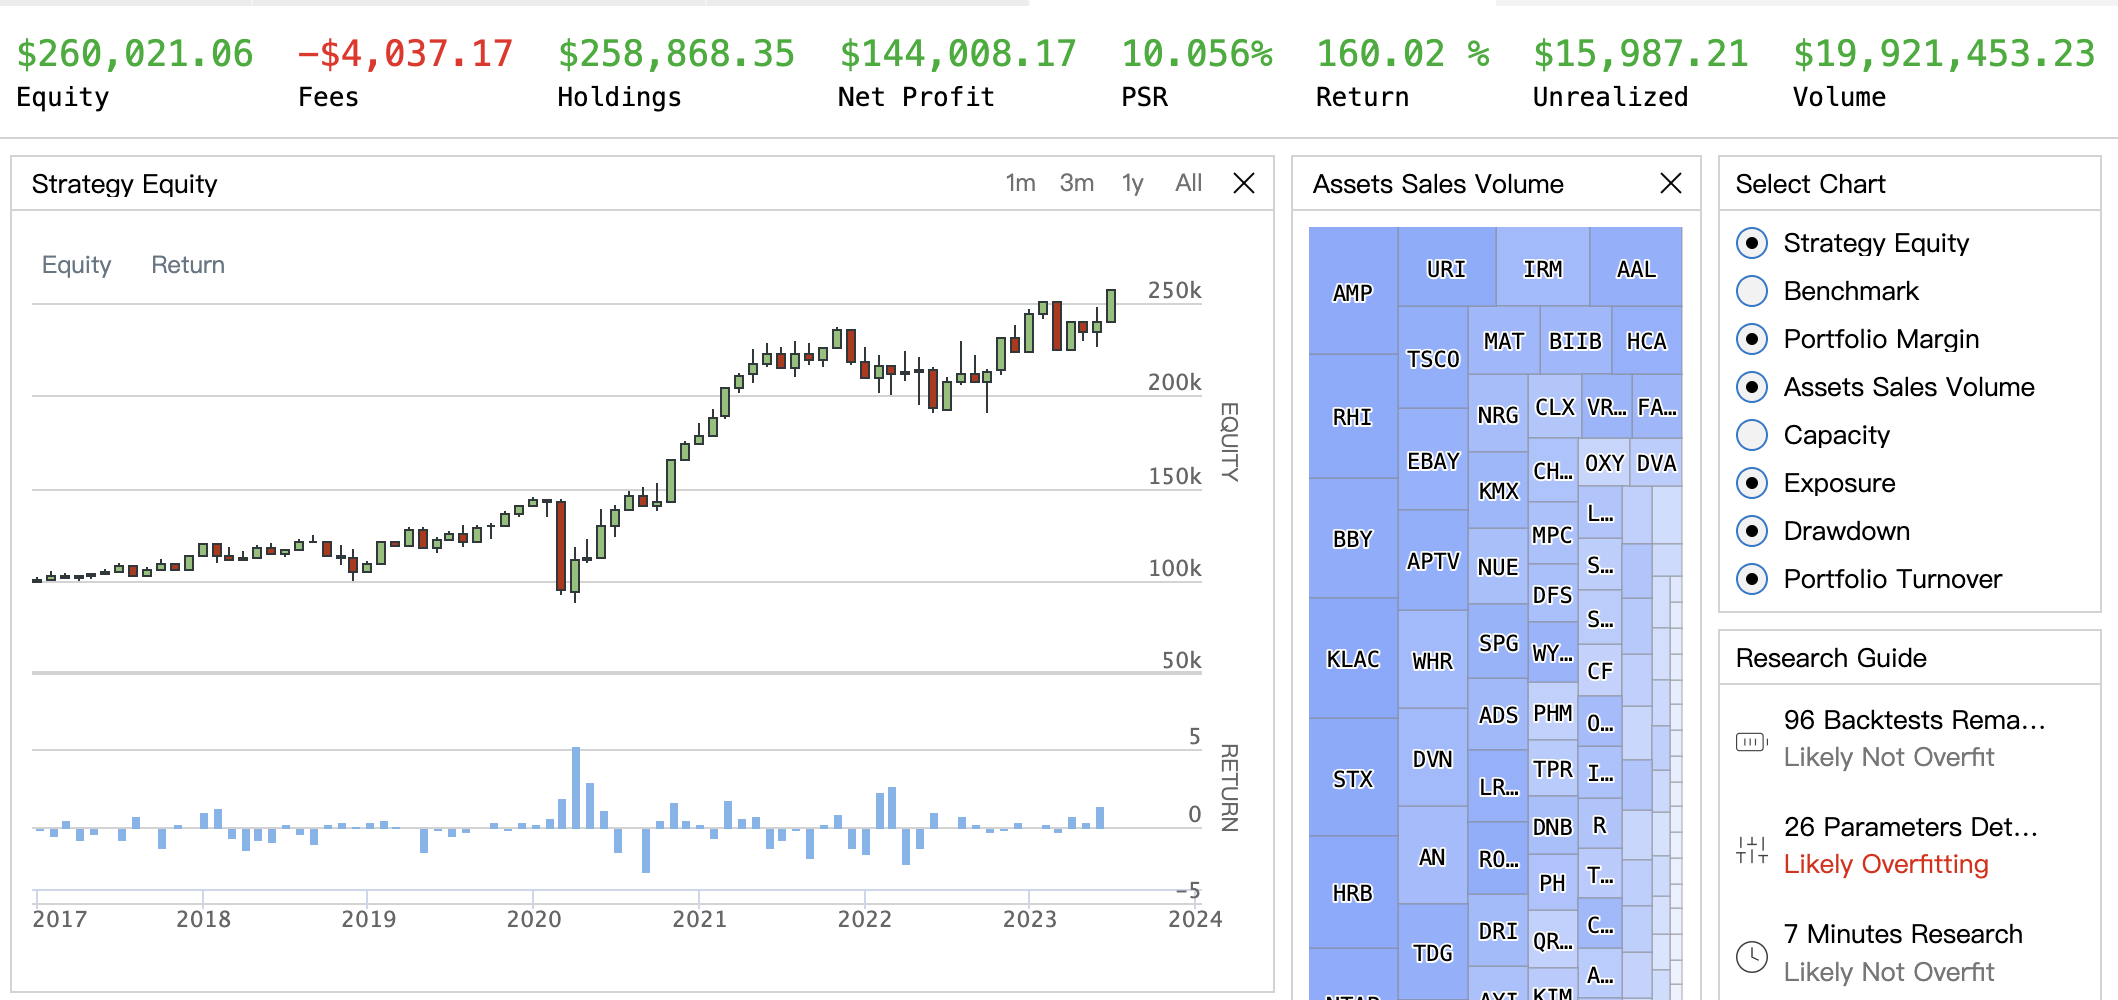

In [14]:
display(Image('截屏2024-05-08 下午5.06.30.png'))